<a href="https://colab.research.google.com/github/Suraj-Kaple/Simple-CNN-classifier-pytorch/blob/main/CNN_%2B_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **<center><font style="color:rgb(100,109,254)">Indoor Human Fall Detection using Deep Learning</font> </center>**

<center>


## **<font style="color:rgb(134,19,348)"> Outline </font>**

- **`Step 1:` Import Necessary libraries.**

- **`Step 2:` Load features and labels from database**

- **`Step 3:` Split the Data into Train and Test Set**

- **`Step 4:` implement the LRCN Approach**

    - **`Step 4.1:` Construct the Model**
    
    - **`Step 4.2:` Compile & Train the Model**
    
    - **`Step 4.3:` Plot Model’s Loss & Accuracy Curves**
    
- **`Step 5:` Test the Model**
- **`Step 6:` Predict the Action on Video having series of actions.**

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

Installing and importing the required libraries.

In [ ]:
%%capture
# Import the required libraries.
import os
import cv2
# import pafy
import math
import random
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import *
import sklearn

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/project/Dataset/NTU/modified") #add path of project directory

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 25

# Specify the directory containing the NTU dataset.
DATASET_DIR = "modified"

# Specify the list containing the names of the classes used for training.
# CLASSES_LIST = ["Sit down",'falling down',"Jump up","Stand up"]
CLASSES_LIST = ["Fall", "Non Fall"]

## **<font style="color:rgb(134,19,348)">Step 1: Load the extracted features</font>**

In [ ]:
os.chdir("/content/drive/MyDrive/project/Dataset/NTU/modified/features")
features = np.load('gray_features_25_frames.npy')
features.shape

(1822, 25, 64, 64)

In [ ]:
labels = np.load('gray_labels_25_frames.npy')
labels.shape

(1822,)

## **<font style="color:rgb(134,19,348)">Step 2: Encode labels with One-hot encoding technique</font>**

Now we will convert `labels` (class indexes) into one-hot encoded vectors.

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)
one_hot_encoded_labels.shape

(2121, 4)

## **<font style="color:rgb(134,19,348)">Step 3: Split the Data into Train and Test Set</font>**

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** So now, we will split our data to create training and testing sets. In order to avoid any bias we shuffle the dataset before the spliting.

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

features_train.shape, labels_train.shape, features_test.shape, labels_test.shape

((1366, 25, 64, 64), (1366, 2), (456, 25, 64, 64), (456, 2))

## **<font style="color:rgb(134,19,348)">Step 4: Implement the LRCN Approach</font>**

In this step, we will implement Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

In [ ]:
# def create_LRCN_model():
#     model = Sequential()

#     model.add(TimeDistributed(Conv2D(16, (3, 3), padding='valid', kernel_initializer = "he_uniform", activation = 'relu'), input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH,1)))
#     model.add(TimeDistributed(Conv2D(16, (3, 3), padding='valid', kernel_initializer = "he_uniform", activation = 'relu')))
#     model.add(TimeDistributed(MaxPooling2D((2, 2))))
#     model.add(TimeDistributed(BatchNormalization(momentum=0.9)))
#     model.add(TimeDistributed(Dropout(0.4)))

#     model.add(TimeDistributed(Conv2D(32, (3, 3), padding='valid', kernel_initializer = "he_uniform", activation = 'relu')))
#     model.add(TimeDistributed(Conv2D(32, (3, 3), padding='valid', kernel_initializer = "he_uniform", activation = 'relu')))
#     model.add(TimeDistributed(MaxPooling2D((2, 2))))
#     model.add(TimeDistributed(BatchNormalization(momentum=0.9)))
#     model.add(TimeDistributed(Dropout(0.4)))

#     model.add(TimeDistributed(Conv2D(64, (3, 3), padding='valid', kernel_initializer = "he_uniform", activation = 'relu')))
#     model.add(TimeDistributed(Conv2D(64, (3, 3), padding='valid', kernel_initializer = "he_uniform", activation = 'relu')))
#     model.add(TimeDistributed(MaxPooling2D((2, 2))))
#     model.add(TimeDistributed(BatchNormalization(momentum=0.9)))
#     model.add(TimeDistributed(Dropout(0.4)))

#     model.add(TimeDistributed(Conv2D(128, (3, 3), padding='valid', kernel_initializer = "he_uniform", activation = 'relu')))
#     # model.add(TimeDistributed(Conv2D(128, (3, 3), padding='valid', kernel_initializer = "he_uniform", activation = 'relu')))
#     model.add(TimeDistributed(MaxPooling2D((2, 2))))
#     model.add(TimeDistributed(BatchNormalization(momentum=0.9)))
#     model.add(TimeDistributed(Dropout(0.4)))

#     # model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', kernel_initializer = "he_uniform", activation = 'relu')))
#     # # model.add(TimeDistributed(Conv2D(128, (3, 3), padding='valid', kernerl_initializer = "he_uniform", activation = 'relu')))
#     # model.add(TimeDistributed(MaxPooling2D((2, 2))))
#     # model.add(TimeDistributed(BatchNormalization(momentum=0.9)))
#     # # model.add(TimeDistributed(Dropout(0.4)))

#     model.add(TimeDistributed(Flatten()))

#     model.add(LSTM(128,return_sequences=True))
#     model.add(LSTM(32,return_sequences=False))

#     model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

#     # Display the models summary.
#     model.summary()

#     # Return the constructed LRCN model.
#     return model

In [ ]:
conv_model = Sequential(
    [
     #CONV BLOCK 1
      TimeDistributed(Conv2D(16, (3, 3), padding = "same", activation = "relu"), input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH,1)),
      TimeDistributed(MaxPooling2D((4, 4))),
      TimeDistributed(Dropout(0.4)),

      #CONV BLOCK 2
      TimeDistributed(Conv2D(32, (3, 3), padding = "same", activation = "relu")),
      TimeDistributed(MaxPooling2D((2, 2))),
      TimeDistributed(Dropout(0.4)),

      #CONV BLOCK 3
      TimeDistributed(Conv2D(64, (3, 3), padding = "same", activation = "relu")),
      TimeDistributed(MaxPooling2D((4, 4))),
      TimeDistributed(Dropout(0.4)),

      #CONV BLOCK 4
      TimeDistributed(Conv2D(128, (3, 3), padding = "same", activation = "relu")),
      TimeDistributed(MaxPooling2D((2, 2))),
      TimeDistributed(Dropout(0.4)),

      # #CONV BLOCK 5
      # TimeDistributed(Conv2D(256, (3, 3), padding = "same", activation = "relu")),
      # TimeDistributed(MaxPooling2D((2, 2))),
      # TimeDistributed(Dropout(0.4)),

      # #CONV BLOCK 6
      # TimeDistributed(Conv2D(512, (3, 3), padding = "same", activation = "relu")),
      # TimeDistributed(MaxPooling2D((2, 2))),
      # TimeDistributed(Dropout(0.4)),
      TimeDistributed(Flatten())
])


LSTM_model=Sequential([
      #LSTM Layer 1 with 128 units
      LSTM(128,return_sequences=True),
      Dropout(0.4),
      #LSTM Layer 2 with 32 units
      LSTM(32,return_sequences=False),
      Dropout(0.4)
])

Dense_model = Sequential([
      # Dense(120, activation = "relu"),
      # Dropout(0.5),
      # Dense(84, activation = "relu"),
      # Dropout(0.5),
      Dense(len(CLASSES_LIST), activation="sigmoid")
])


In [ ]:
LRCN_model = load_model("/content/drive/MyDrive/project/Dataset/NTU/modified/LRCN Models/LRCN_model_Accuracy_0.903954803943634_Loss_0.2377118319272995_2022_04_05__10_46_59.h5")

In [ ]:
for i in range(13):
  conv_model.layers[i]=new_model.layers[i]

In [ ]:
# LRCN_model=load_model("/content/drive/MyDrive/project/Dataset/NTU/modified/LRCN Models/LRCN_model_Accuracy_0.9758771657943726_Loss_0.1112920492887497_2022_04_06__06_15_47.h5")

In [ ]:
LRCN_model = Sequential([conv_model,
                         LSTM_model,
                         Dense_model])

conv_model.trainable = True
LSTM_model.trainable = True
Dense_model.trainable = True

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [ ]:
# # Construct the required LRCN model.
# LRCN_model = create_LRCN_model()
# print("Model Created Successfully!")

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

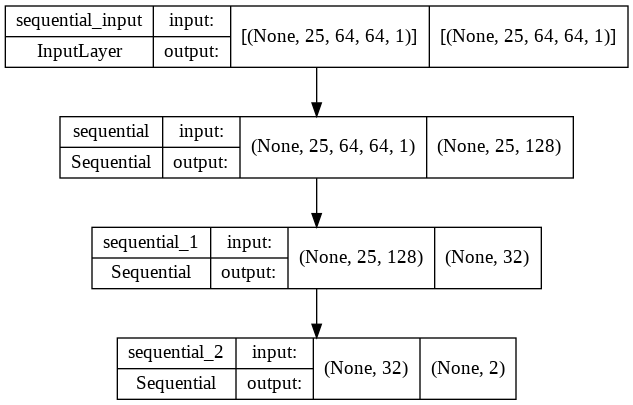

In [ ]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True)

### **<font style="color:rgb(134,19,348)">Step 4.3: Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 200, batch_size = 32,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/200
35/35 [==============================] - 23s 158ms/step - loss: 0.1046 - accuracy: 0.9661 - val_loss: 0.1132 - val_accuracy: 0.9380
Epoch 2/200
35/35 [==============================] - 4s 111ms/step - loss: 0.0750 - accuracy: 0.9734 - val_loss: 0.1897 - val_accuracy: 0.9416
Epoch 3/200
35/35 [==============================] - 4s 111ms/step - loss: 0.1040 - accuracy: 0.9661 - val_loss: 0.0987 - val_accuracy: 0.9672
Epoch 4/200
35/35 [==============================] - 4s 111ms/step - loss: 0.0716 - accuracy: 0.9725 - val_loss: 0.1374 - val_accuracy: 0.9453
Epoch 5/200
35/35 [==============================] - 4s 110ms/step - loss: 0.0919 - accuracy: 0.9707 - val_loss: 0.1186 - val_accuracy: 0.9489
Epoch 6/200
35/35 [==============================] - 4s 111ms/step - loss: 0.0854 - accuracy: 0.9707 - val_loss: 0.1259 - val_accuracy: 0.9453
Epoch 7/200
35/35 [==============================] - 4s 111ms/step - loss: 0.0871 - accuracy: 0.9725 - val_loss: 0.1175 - val_accuracy: 0.956

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**


In [ ]:
# LRCN_model = load_model("/content/drive/MyDrive/project/Dataset/NTU/modified/LRCN Models/LRCN_model_Accuracy_0.9453860521316528_Loss_0.26018214225769043_2022_02_28__06_12_59.h5")

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

15/15 [==============================] - 1s 43ms/step - loss: 0.1008 - accuracy: 0.9715


In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Training Loss vs Validation Loss')

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Training Accuracy vs Validation Accuracy')

15/15 [==============================] - 2s 33ms/step
[[229   5]
 [  8 214]]
              precision    recall  f1-score   support

        Fall       0.97      0.98      0.97       234
    Non Fall       0.98      0.96      0.97       222

    accuracy                           0.97       456
   macro avg       0.97      0.97      0.97       456
weighted avg       0.97      0.97      0.97       456



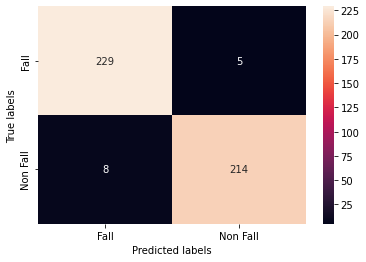

In [ ]:
ypred = LRCN_model.predict(features_test, verbose=1)
ypred = np.argmax(ypred, axis=1)
x = np.argmax(labels_test, axis=1)

cm = confusion_matrix(x, ypred)
print(cm)

target_names = CLASSES_LIST
# print('roc_auc_score for DecisionTree: ', roc_auc_score(x, ypred))

print(classification_report(np.argmax(labels_test, axis=1), ypred, target_names=target_names))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names);


### **<font style="color:rgb(134,19,348)">Step 4.4: Plot Model’s Loss & Accuracy Curves</font>**

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model_Accuracy_{model_evaluation_accuracy}_Loss_{model_evaluation_loss}_{current_date_time_string}.h5'
os.chdir("/content/drive/MyDrive/project/Dataset/NTU/modified/LRCN Models")
# Save the Model.
LRCN_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Testing on a Video:</font>**


In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

video_title = "model_output"

input_video_file_path = "/content/drive/MyDrive/NTU/modified/test_videos/S012C001P007R001A008_rgb.mp4"

### **<font style="color:rgb(134,19,348)">Create a Function To Perform Action Recognition on Videos</font>**

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
    Q = deque(maxlen = 5)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Convert RGB frame to Gray Scale
        gframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(gframe, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        if predicted_label==1:
          Q.append(predicted_label)
        else:
          Q.append(0)

        if len(Q)==5:
          # Write Fall/Non-Fall class name on top of the frame.
          if sum(Q)/5 > 0.5:
            cv2.putText(frame, "Falling", (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 255), 2)
          else:
            cv2.putText(frame, "Non-Falling", (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

### **<font style="color:rgb(134,19,348)">Perform Action Recognition on the Test Video</font>**


In [ ]:
# Construct the output video path.
os.chdir("/content/drive/MyDrive/project/Dataset/NTU/modified")
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# # Display the output video.
# VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

In [ ]:
os.getcwd()

'/content/drive/MyDrive/project/Dataset/NTU'